# Car price prediction Midterm Project

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle

from sklearn.tree import export_text
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from matplotlib import pyplot as plt
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import mutual_info_score

from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import xgboost as xgb

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

from tqdm.auto import tqdm

In [2]:
df = pd.read_csv('resources/train.csv')

## 1. Cleaning and EDA

In [3]:
df.head()

,ID,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4


In [4]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [5]:
df

,id,price,levy,manufacturer,model,prod._year,category,leather_interior,fuel_type,engine_volume,mileage,cylinders,gear_box_type,drive_wheels,doors,wheel,color,airbags
0,45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,04-May,Left wheel,Silver,12
1,44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,04-May,Left wheel,Black,8
2,45774419,8467,-,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,04-May,Right-hand drive,Black,2
3,45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,04-May,Left wheel,White,0
4,45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,04-May,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19232,45798355,8467,-,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,300000 km,4.0,Manual,Rear,02-Mar,Left wheel,Silver,5
19233,45778856,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600 km,4.0,Tiptronic,Front,04-May,Left wheel,Red,8
19234,45804997,26108,836,HYUNDAI,Tucson,2010,Jeep,Yes,Diesel,2,116365 km,4.0,Automatic,Front,04-May,Left wheel,Grey,4
19235,45793526,5331,1288,CHEVROLET,Captiva,2007,Jeep,Yes,Diesel,2,51258 km,4.0,Automatic,Front,04-May,Left wheel,Black,4


In [6]:
df = df.drop(['id'], axis=1)
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

#convert values of all cols to lowercase
for col in categorical_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [7]:
df['mileage'] = df['mileage'].str.lower().str.replace('_km', '')

In [8]:
# split column into multiple columns by delimiter 
df['doors'] = df['doors'].str.split('-', expand=True)[0].str.replace('0', '')
df['doors'] = df['doors'].str.split('-', expand=True)[0].str.replace('>', '')
df['doors'] = df['doors'].astype(int)

In [9]:
df[['engine_volume', 'turbo']] = df['engine_volume'].str.split('_', expand=True)
df['turbo'] = df['turbo'].fillna('normal')
df['engine_volume'] = df['engine_volume'].astype(float)
df['levy'] = df['levy'].replace([r'-'], '', regex=True)
df['levy']= df['levy'].apply(pd.to_numeric)
df['levy']= df['levy'].fillna(0)
df['mileage'] = df['mileage'].astype(int)

In [10]:
df = df.sample(frac=1, random_state=1)
df

,price,levy,manufacturer,model,prod._year,category,leather_interior,fuel_type,engine_volume,mileage,cylinders,gear_box_type,drive_wheels,doors,wheel,color,airbags,turbo
15541,314,1869.0,chevrolet,traverse,2019,sedan,yes,petrol,3.6,37480,6.0,automatic,front,4,left_wheel,grey,12,normal
2811,20171,707.0,ssangyong,rexton,2011,jeep,yes,diesel,2.0,148427,4.0,automatic,front,4,left_wheel,black,4,normal
9871,1803,528.0,hyundai,accent,2014,hatchback,yes,petrol,1.6,82602,4.0,automatic,front,4,left_wheel,blue,12,normal
11117,17876,645.0,toyota,prius,2011,sedan,yes,hybrid,1.8,129000,4.0,variator,front,4,left_wheel,grey,4,normal
16832,9800,707.0,ford,transit_connect,2011,goods_wagon,no,petrol,2.0,161000,4.0,automatic,front,4,left_wheel,white,5,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,31361,3894.0,bmw,x5_4.8is,2005,jeep,yes,petrol,4.8,147200,8.0,tiptronic,4x4,4,left_wheel,silver,12,normal
17289,1882,1053.0,mercedes-benz,e_350,2014,sedan,yes,petrol,3.5,146395,6.0,automatic,rear,4,left_wheel,grey,12,normal
5192,39750,730.0,ssangyong,actyon,2016,jeep,yes,diesel,1.6,68942,4.0,automatic,front,4,left_wheel,white,4,normal
12172,14113,638.0,kia,optima,2014,sedan,yes,petrol,2.0,45504,4.0,automatic,front,4,left_wheel,black,4,normal


In [11]:
df.isnull().sum()

price               0
levy                0
manufacturer        0
model               0
prod._year          0
category            0
leather_interior    0
fuel_type           0
engine_volume       0
mileage             0
cylinders           0
gear_box_type       0
drive_wheels        0
doors               0
wheel               0
color               0
airbags             0
turbo               0
dtype: int64

In [12]:
df.dtypes

price                 int64
levy                float64
manufacturer         object
model                object
prod._year            int64
category             object
leather_interior     object
fuel_type            object
engine_volume       float64
mileage               int64
cylinders           float64
gear_box_type        object
drive_wheels         object
doors                 int64
wheel                object
color                object
airbags               int64
turbo                object
dtype: object

In [13]:
categorical = [
    'manufacturer',
    'model',
    'category',
    'leather_interior',
    'fuel_type',
    'gear_box_type',
    'drive_wheels',
    'wheel',
    'color'
]


numerical = [
    'engine_volume',
    'levy',
    'mileage',
    'prod._year',
    'cylinders',
    'airbags',
    'doors',
]

features = categorical + numerical

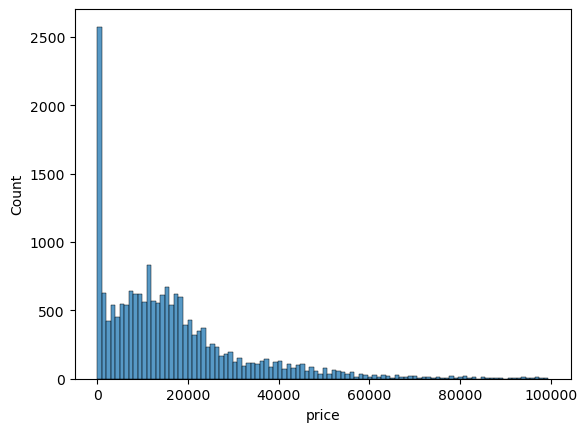

In [14]:
sns.histplot(df.price[df.price <100000], bins = 100)
plt.show()

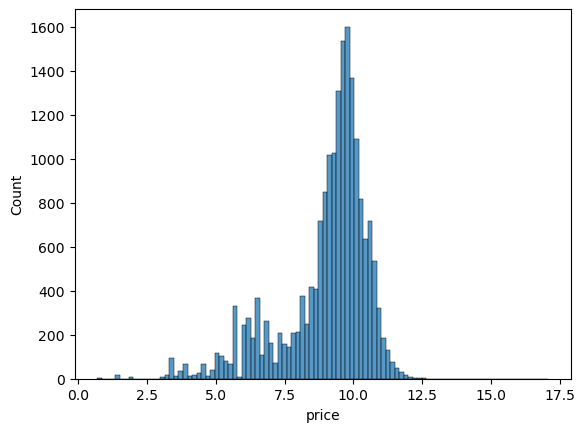

In [15]:
price_logs = np.log1p(df.price)
sns.histplot(price_logs, bins = 100)
plt.show()

In [16]:
df.describe().round()

,price,levy,prod._year,engine_volume,mileage,cylinders,doors,airbags
count,19237.0,19237.0,19237.0,19237.0,1.923700e+04,19237.0,19237.0,19237.0
mean,18556.0,633.0,2011.0,2.0,1.532236e+06,5.0,4.0,7.0
std,190581.0,568.0,6.0,1.0,4.840387e+07,1.0,0.0,4.0
min,1.0,0.0,1939.0,0.0,0.000000e+00,1.0,2.0,0.0
25%,5331.0,0.0,2009.0,2.0,7.013900e+04,4.0,4.0,4.0
50%,13172.0,642.0,2012.0,2.0,1.260000e+05,4.0,4.0,6.0
75%,22075.0,917.0,2015.0,2.0,1.888880e+05,4.0,4.0,12.0
max,26307500.0,11714.0,2020.0,20.0,2.147484e+09,16.0,5.0,16.0


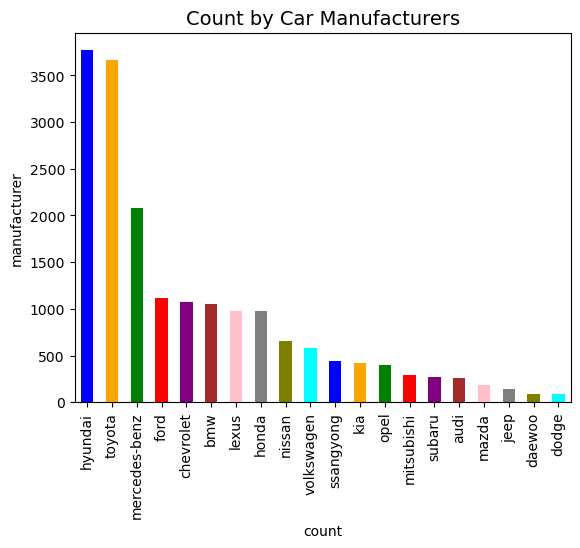

In [17]:
colors= ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']

df['manufacturer'].value_counts().head(20).plot.bar(color=colors)
plt.title('Count by Car Manufacturers', fontsize=14)
plt.xlabel('count', fontsize=10)
plt.ylabel('manufacturer', fontsize=10)
plt.show()

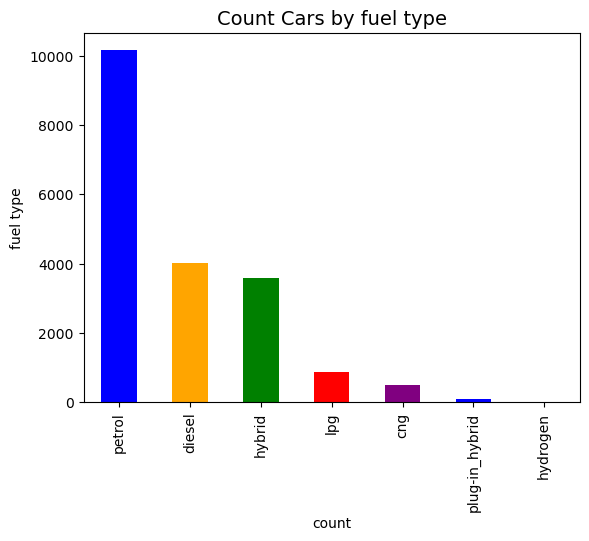

In [18]:
colors= ['blue', 'orange', 'green', 'red', 'purple']

df['fuel_type'].value_counts().plot.bar(color=colors)

plt.title('Count Cars by fuel type', fontsize=14)
plt.xlabel('count', fontsize=10)
plt.ylabel('fuel type', fontsize=10)

plt.show()

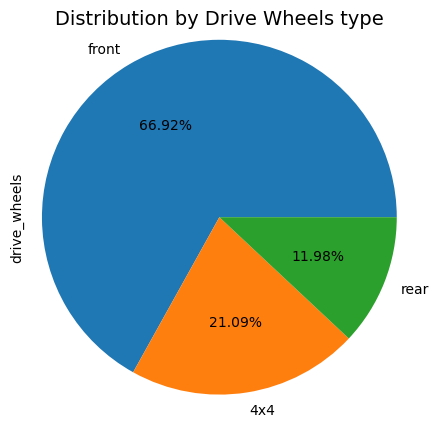

In [19]:
df['drive_wheels'].value_counts().plot.pie(radius=1.2,autopct='%0.2f%%')
plt.title('Distribution by Drive Wheels type', fontsize=14)
plt.show()

In [20]:
df[numerical].corrwith(df.price)

engine_volume    0.008753
levy            -0.003701
mileage         -0.001758
prod._year       0.012982
cylinders        0.007518
airbags         -0.012824
doors           -0.033116
dtype: float64

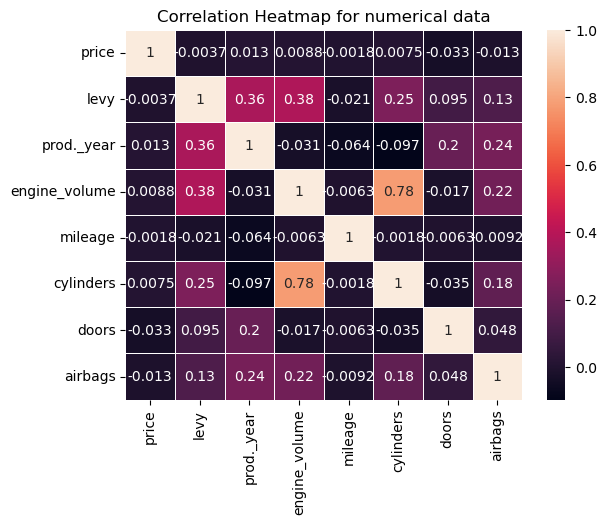

In [21]:
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, linewidths=.5)
plt.title('Correlation Heatmap for numerical data')
plt.show()

In [22]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [23]:
def mutual_info_price_score(series):
    return mutual_info_score(series, df_full_train.price)

mi = df_full_train[categorical].apply(mutual_info_price_score)
mi.sort_values(ascending=False)

model               2.614074
manufacturer        0.952299
color               0.489792
category            0.441978
fuel_type           0.378473
gear_box_type       0.299489
drive_wheels        0.212024
leather_interior    0.207003
wheel               0.094339
dtype: float64

In [24]:
y_train = np.log1p(df_train.price.values)
y_val = np.log1p(df_val.price.values)
y_test = np.log1p(df_test.price.values)

del df_train['price']
del df_val['price']
del df_test['price']

In [25]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [26]:
val_dicts= df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

## 2. Linear regression

In [27]:
lreg = LinearRegression()

In [28]:
lreg.fit(X_train, y_train)

LinearRegression()

In [29]:
y_pred = lreg.predict(X_val)

In [30]:
np.round(np.sqrt(mean_squared_error(y_val, y_pred)),2)

1.72

In [32]:
r2 = r2_score(y_val, y_pred)
r2

-0.18919467701477055

## 3. Decision trees 

In [33]:
dt = DecisionTreeRegressor()
dt.fit(X_train, y_train)

DecisionTreeRegressor()

In [34]:
y_pred = dt.predict(X_val)

In [35]:
np.round(np.sqrt(mean_squared_error(y_val, y_pred)),2)

1.21

In [37]:
r2 = r2_score(y_val, y_pred)
r2

0.4110763784745364

In [38]:
for depth in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    dt = DecisionTreeRegressor(max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict(X_val)
    score = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    print(f'depth: {depth}, rmse: {round((score),3)}, r2: {round((r2),3)}')

depth: 1, rmse: 2.317, r2: 0.071
depth: 2, rmse: 1.873, r2: 0.25
depth: 3, rmse: 1.693, r2: 0.322
depth: 4, rmse: 1.64, r2: 0.343
depth: 5, rmse: 1.528, r2: 0.388
depth: 6, rmse: 1.458, r2: 0.416
depth: 10, rmse: 1.493, r2: 0.402
depth: 15, rmse: 1.435, r2: 0.425
depth: 20, rmse: 1.436, r2: 0.424
depth: None, rmse: 1.527, r2: 0.388


In [39]:
scores = []

for m in [1, 2, 3, 4, 5, 6, 10, 15, 20, None]:
    #print('depth: %s' % m)
    for s in [1, 5, 10, 15, 20, 50, 100, 200]:
        dt = DecisionTreeRegressor(max_depth=m, min_samples_leaf=s)
        dt.fit(X_train, y_train)
        y_pred = dt.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        
        scores.append((m, s, score, r2))
        #print(f'depth: {m}, mean leafs: {s}, rmse: {round((score),3)}, r2: {round((r2),3)}')

In [40]:
columns = ['max_depth', 'min_sample_leaves', 'rmse', 'r2']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores = df_scores.sort_values(by='rmse', ascending=True)
df_scores

,max_depth,min_sample_leaves,rmse,r2
65,20.0,5,1.103507,0.511980
73,NaN,5,1.110319,0.505935
66,20.0,10,1.111446,0.504932
74,NaN,10,1.112474,0.504016
76,NaN,20,1.113614,0.502999
...,...,...,...,...
2,1.0,10,1.522160,0.071443
1,1.0,5,1.522160,0.071443
0,1.0,1,1.522160,0.071443
7,1.0,200,1.522160,0.071443


In [41]:
df_scores_pivot =  df_scores.pivot(index='min_sample_leaves',
                                   columns=['max_depth'], values=['rmse'])
df_scores_pivot.round(3)

rmse                                                   \
max_depth            NaN   1.0    2.0    3.0    4.0    5.0    6.0    10.0   
min_sample_leaves                                                           
1                  1.237  1.522  1.368  1.301  1.281  1.229  1.205  1.201   
5                  1.110  1.522  1.368  1.301  1.273  1.226  1.202  1.175   
10                 1.112  1.522  1.368  1.301  1.273  1.227  1.197  1.166   
15                 1.116  1.522  1.368  1.301  1.273  1.232  1.209  1.167   
20                 1.114  1.522  1.368  1.301  1.273  1.231  1.210  1.162   
50                 1.162  1.522  1.368  1.301  1.273  1.231  1.210  1.173   
100                1.215  1.522  1.368  1.301  1.264  1.244  1.234  1.221   
200                1.223  1.522  1.368  1.301  1.260  1.241  1.227  1.223   

                                 
max_depth           15.0   20.0  
min_sample_leaves                
1                  1.183  1.199  
5                  1.136  1.104  
10                 1.118  1.111  
15                 1.124  1.117  
20                 1.115  1.114  
50                 1.161  1.162  
100                1.215  1.215  
200                1.223  1.223

<AxesSubplot:xlabel='None-max_depth', ylabel='min_sample_leaves'>

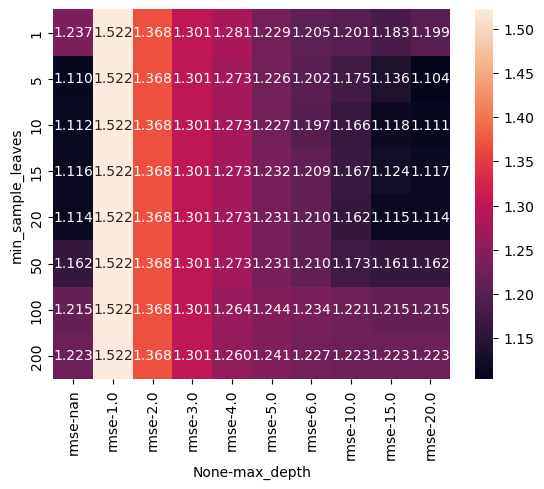

In [42]:
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [43]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

RandomForestRegressor()

In [44]:
y_pred = rf.predict(X_val)

In [45]:
score = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

score, r2

(0.9664809182144937, 0.6256529302379527)

# 4.1 Tuning Random Forest 

#### 4.1.1 tuning n_estimators

In [46]:
scores = []

for n in tqdm(range(10, 201, 10)):
    rf = RandomForestRegressor(n_estimators=n,
                                random_state=1,
                                n_jobs=-1)
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    scores.append((n, score, r2))

  0%|          | 0/20 [00:00<?, ?it/s]

In [49]:
columns = ['n_estimators', 'rmse', 'r2']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores = df_scores.sort_values(by='rmse', ascending=True)
df_scores.head(10)

,n_estimators,rmse,r2
18,190,0.965216,0.626632
17,180,0.965254,0.626602
19,200,0.965484,0.626424
15,160,0.965702,0.626256
16,170,0.965763,0.626209
11,120,0.966066,0.625974
10,110,0.966112,0.625938
14,150,0.966145,0.625913
12,130,0.966212,0.625861
13,140,0.966351,0.625753


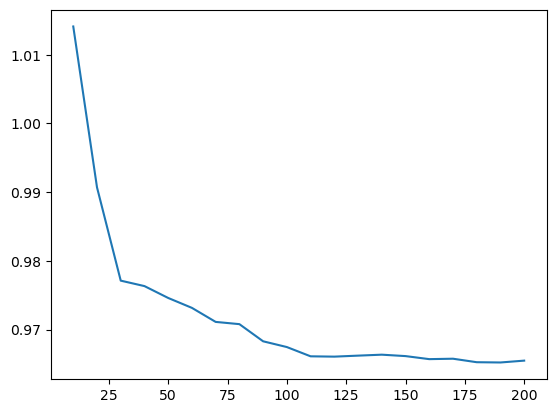

In [48]:
columns = ['n_estimators','rmse', 'r2']
df_scores = pd.DataFrame(scores, columns=columns)
plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.show()

#### 4.1.2 tuning n_estimators and depth

## 4. Random Forest

In [50]:
scores = []

for d in tqdm([5, 10, 15, 20, 25, 30, None]):
    
    for n in tqdm(range(10, 201, 10)):
        
        rf = RandomForestRegressor(n_estimators=n,
                                        max_depth=d,
                                        random_state=1,
                                        n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))
        r2 = r2_score(y_val, y_pred)
        scores.append((n, d, score, r2))

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [51]:
columns = ['n_estimators', 'max_depth', 'rmse', 'r2']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.sort_values(by='rmse', ascending=True)

,n_estimators,max_depth,rmse,r2
111,120,30.0,0.962999,0.628346
110,110,30.0,0.963428,0.628014
112,130,30.0,0.963659,0.627836
114,150,30.0,0.964126,0.627475
115,160,30.0,0.964301,0.627340
...,...,...,...,...
2,30,5.0,1.208376,0.414816
4,50,5.0,1.208515,0.414682
3,40,5.0,1.208838,0.414369
0,10,5.0,1.209320,0.413902


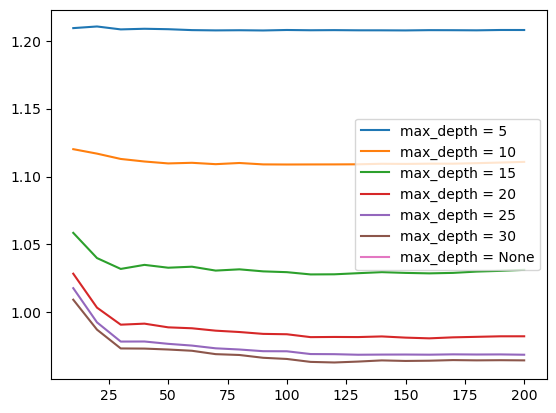

In [54]:
for d in [5, 10, 15, 20, 25, 30, None]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=f'max_depth = {d}')
    
plt.legend()
plt.show()

In [55]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.get_feature_names_out()
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False).head(5)

,feature,importance
0,airbags,0.157670
110,mileage,0.137184
1244,prod._year,0.110894
40,gear_box_type=automatic,0.107496
46,levy,0.080411


## 5. XGBoost 

In [56]:
features = dv.get_feature_names_out()
features

array(['airbags', 'category=cabriolet', 'category=coupe', ...,
       'prod._year', 'wheel=left_wheel', 'wheel=right-hand_drive'],
      dtype=object)

In [57]:
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [58]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

### 5.1 Tuning XGboost 

#### 5.1.1 Tuning eta 

In [59]:
scores_eta = {}
# 0.3, 0.2, 0.15, 0.1, 0.05, 0.01

In [90]:
%%capture output
xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals=watchlist,
                  num_boost_round=100)

In [91]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        
        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [92]:
#the output is captured by "%%capture output"
df_score = parse_xgb_output(output)
df_score

,num_iter,train_rmse,val_rmse
0,0,8.59502,8.58706
1,1,8.51085,8.50292
2,2,8.42753,8.41963
3,3,8.34506,8.33724
4,4,8.26343,8.25569
...,...,...,...
95,95,3.47392,3.48006
96,96,3.44274,3.44919
97,97,3.41194,3.41861
98,98,3.38143,3.38838


In [93]:
key_text_eta = f"eta = {xgb_params['eta']}"
scores_eta[key_text_eta] = parse_xgb_output(output)
key_text_eta

'eta = 0.01'

In [94]:
scores_eta.keys()

dict_keys(['eta = 0.3', 'eta = 0.2', 'eta = 0.15', 'eta = 0.1', 'eta = 0.05', 'eta = 0.01'])

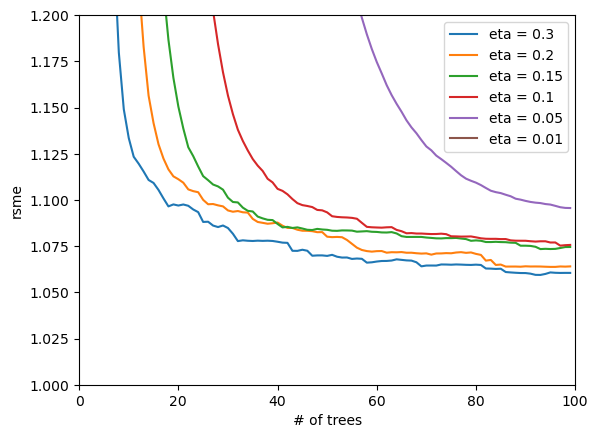

In [95]:
for key_eta, df_score in scores_eta.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=key_eta)

plt.ylabel('rsme')
plt.xlabel('# of trees')

plt.xlim((0, 100))
plt.ylim((1, 1.2))


plt.legend()
plt.show()

# eta 0.1 and .15

In [138]:
y_pred = model.predict(dval)

In [146]:
score = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

score, r2
#.3

(3.4495980889130737, -4.083644784361006)

#### 5.1.2 Tuning max_depth

In [96]:
scores_depth = {}
# 1, 3, 5, 10, 15, 25, 30

In [126]:
%%capture output
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals=watchlist,
                  num_boost_round=100)

In [127]:
key_text_depth = f"max_depth = {xgb_params['max_depth']}"
scores_depth[key_text_depth] = parse_xgb_output(output)
key_text_depth

'max_depth = 3'

In [128]:
#scores is a dictionary and by key_text we ccess to the first element
#scores_depth[key_text_depth]

In [129]:
scores_depth.keys()

dict_keys(['max_depth = 30', 'max_depth = 25', 'max_depth = 15', 'max_depth = 10', 'max_depth = 5', 'max_depth = 3'])

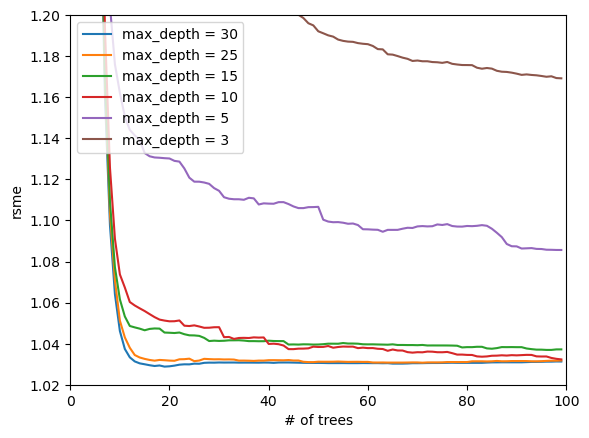

In [166]:
for key_text_depth, df_score in scores_depth.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=key_text_depth)

plt.ylabel('rsme')
plt.xlabel('# of trees')

plt.ylabel('rsme')
plt.xlabel('# of trees')

plt.xlim((0, 100))
plt.ylim((1.02, 1.2))


plt.legend()
plt.show()

#max_depth 25 or 30

#### 5.1.3 Tuning min_child_weight

In [135]:
scores_min_child = {}
# 1, 5, 10, 15, 25

In [153]:
%%capture output
xgb_params = {
    'eta': 0.1, 
    'max_depth': 25,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals=watchlist,
                  num_boost_round=100)

In [154]:
key_text_min = f"min_child = {xgb_params['min_child_weight']}"
scores_min_child[key_text_min] = parse_xgb_output(output)
key_text_min

'min_child = 1'

In [155]:
scores_min_child.keys()

dict_keys(['min_child = 25', 'min_child = 15', 'min_child = 10', 'min_child = 5', 'min_child = 1'])

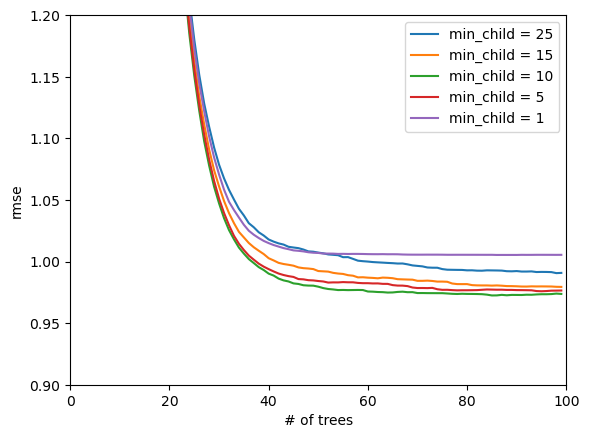

In [156]:
for key_min_child, df_score in scores_min_child.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=key_min_child)

plt.ylabel('rmse')
plt.xlabel('# of trees')

plt.xlim((0, 100))
plt.ylim((.9, 1.2))

plt.legend()
plt.show()

#min_child = 10

## 6. Selecting Best Model 

### 6.1 Linear Regression

In [157]:
lreg = LinearRegression()

In [158]:
lreg.fit(X_train, y_train)

LinearRegression()

In [159]:
y_pred = lreg.predict(X_val)

In [160]:
score = np.round(np.sqrt(mean_squared_error(y_val, y_pred)),2)
r2 = r2_score(y_val, y_pred)

score, r2

(1.72, -0.18919467701477055)

### 6.2 Decision Trees

In [161]:
dt = DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=20, min_samples_leaf=5)

In [162]:
y_pred = dt.predict(X_val)
score = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

score, r2

(1.1050197562352155, 0.5106405769016451)

### 6.3 Random Forest

In [163]:
rf = RandomForestRegressor(n_estimators=120,
                            random_state=1,
                            max_depth=30,
                            n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=30, n_estimators=120, n_jobs=-1, random_state=1)

In [164]:
y_pred = rf.predict(X_val)

In [165]:
score = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

score, r2

(0.9629986467442875, 0.628345647027321)

### 6.4 XGBoost

## 5. XGBoost

In [170]:
%%capture output
xgb_params = {
    'eta': 0.3, 
    'max_depth': 30,
    'min_child_weight': 10,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain,
                  evals=watchlist,
                  num_boost_round=100)

In [171]:
y_pred = model.predict(dval)

In [172]:
score = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

score, r2

(1.0146458461274157, 0.5874117709116222)

## 7. Applying test dataset to selected model 

In [173]:
y_full_train = np.log1p(df_full_train.price.values)
del df_full_train['price']

In [174]:
full_train_dicts = df_full_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(full_train_dicts)

test_dicts= df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dicts)

In [175]:
rf = RandomForestRegressor(n_estimators=120,
                            random_state=1,
                            max_depth=30,
                            n_jobs=-1)
rf.fit(X_full_train, y_full_train)

RandomForestRegressor(max_depth=30, n_estimators=120, n_jobs=-1, random_state=1)

In [176]:
y_pred = rf.predict(X_test)

In [177]:
score = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

score, r2

(0.9466520166850689, 0.650294642423591)

## 8. Saving the model 

In [178]:
def train(df_train, y_train):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = RandomForestRegressor(n_estimators=190,
                            random_state=1,
                            max_depth=30,
                            n_jobs=-1)
    model.fit(X_train, y_train)
    
    return dv, model

In [179]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(dicts)
    y_pred = model.predict(X)
    
    return y_pred

In [180]:
dv, model = train(df_full_train, y_full_train)

In [181]:
y_pred = predict(df_test, dv, model)

In [182]:
score = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

score, r2

(0.9463966380297925, 0.6504832972537882)

In [191]:
# use pickle.dump() function to store the object data to the file.
output_file = 'model.bin'
output_file

'model.bin'

In [192]:
f_out = open('output_file', 'wb')
pickle.dump((dv, model), f_out)
f_out.close()

In [193]:
with open(output_file, 'wb') as f_out:
    pickle.dump((dv, model), f_out)

In [194]:
with open(output_file, 'rb') as f_in:
    dv, model = pickle.load(f_in)

In [195]:
dv, model

(DictVectorizer(sparse=False),
 RandomForestRegressor(max_depth=30, n_estimators=190, n_jobs=-1, random_state=1))

In [196]:
test_car = {
    'manufacturer': 'bmw',
    'model': '118_2,0',
    'category': 'hatchback',
    'leather_interior': 'yes',
    'fuel_type': 'diesel',
    'gear_box_type': 'manual',
    'drive_wheels': 'rear',
    'wheel': 'left_wheel',
    'color': 'beige',
    'engine_volume': 2.0,
    'levy': 500.0,
    'mileage': 188000,
    'prod._year': 2015,
    'cylinders': 4.0,
    'airbags': 10,
    'doors': 4
}

In [197]:
X = dv.transform([test_car])

In [198]:
model.predict(X)

array([10.3168228])